# 8-inch ported bass speaker

Francis Deck

Nov. 11, 2023

***I have taken my design notebook and added some explanatory text. The notebook includes both of my current designs.***

***Also, at present, I'm planning for a re-design and build soon, to see if I can improve the port air speed problem.***

This is my 8-inch ported bass speaker design, using a Faital Pro 8PR200 lightweight driver. I've been using it for several years, and have finally gotten around to writing it up. At present, I'm using it for all of my gigging on upright and electric bass. It's not perfect, as I'll discuss, but quite a capable speaker for its intended uses.

Builders should note that my construction "plans" are going to be quite sparse, because I don't work from plans. I write down the dimensions that I've worked out in my modeling program, then I go into the garage and start cutting plywood.

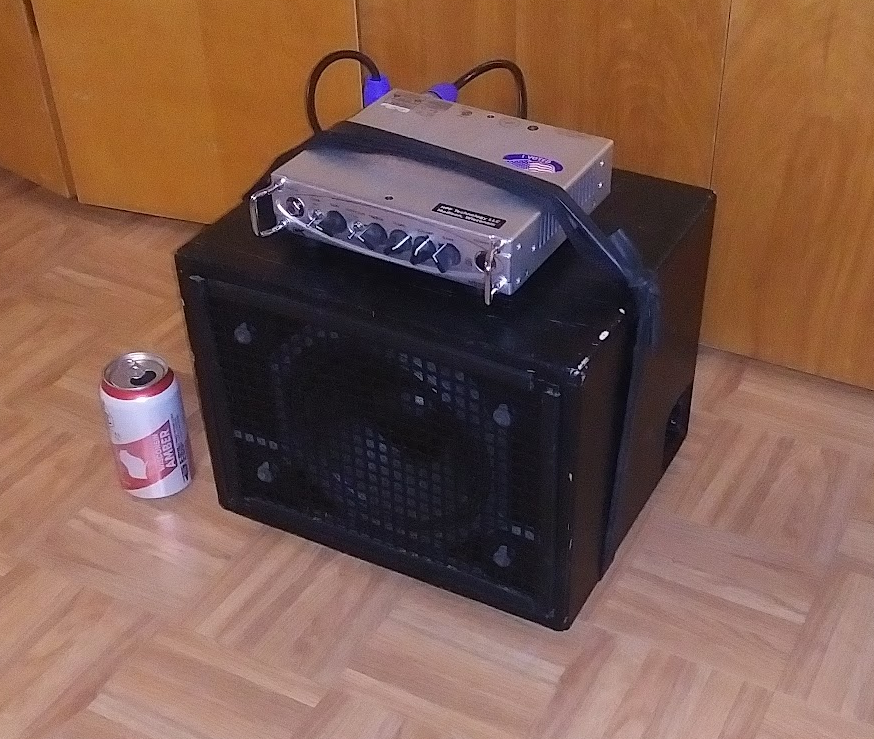

## Motivation and design goals

My approach to speaker design is mainly to wait for the right driver to come along. Sometimes I wait a long time. I take note of drivers that have caught the interest of builders, and plug them into my software. If a driver looks like it can be turned into a promising design, then I take it further. This is what happened with my 12" design, based on an Eminence 2512-ii driver, and now with the 8PR200.

The 8PR200 is a lightweight 8" driver with respectable characteristics: A low resonant frequency means that it can be designed into a relatively compact bass speaker, perhaps at the expense of overall sensitivity. Generous Xmax of 8 mm means it will produce a fair amount of sound. I don't have an eye for the Q specs, so I just plug drivers into my program and see what happens.

I play upright and electric bass, mostly jazz. I still have the 12" speaker at my disposal, but if a jazz gig needs more sound then the 8"er can put out, it's too loud.

## The "small box crisis"

I'm going to start with the port air speed curve.

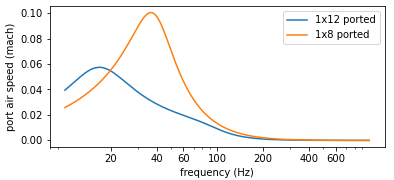

A widespread rule of thumb is that the port air speed should be kept below 10% of the speed of sound, i.e., 0.1 Mach. *We've got a problem*. The 8" design is too close to 0.1 Mach for comfort.

The port air speed could be reduced with a larger port area or diameter, but only by increasing its length to an extreme leading to impractical box dimensions. This is what I call the "small box crisis." Small box plus large Xmax leads to a port that can grow to the size of the box itself. Big box negates the benefit of a small driver.

At the very least, the box requires careful port design. A respected builder on TalkBass, Duke LeJeune, recommends cutting the inside end of the port at an oblique angle as a sort of poor man's flare. The outside should also be flared if possible. But at the end of the day, this box will probably require a high pass filter (HPF) to be functional at higher volumes. I don't plan on ever pushing it beyond 100 Watts.

I feel kind of guilty about that, because I sell HPF's, and seems unfair to share a box design that forces you to buy my stuff. But it's something that you need to be aware of.

Next comes excursion. This plot shows cone excursion at 100 Watts:

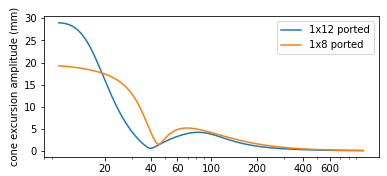

The excursion limit for the 8PR200 driver at 100 Watts is a generous 8 mm. My design will handle 100 Watts without difficulty, especially given that the bass signal is a mixture of harmonics. Why did I choose that power level? It's consistent with the output voltage of my amplifier when it's driven with a sine wave to the threshold of its built-in limiter, so it's a realistic maximum for my typical use.

Besides, port air speed is also a power limit for the design. The impact of the "small box crisis" is that the port becomes the factor that limits power. Small speakers have no secrets that allow them to bypass the laws of physics.

Now, how's it sound? Here's the response curve:

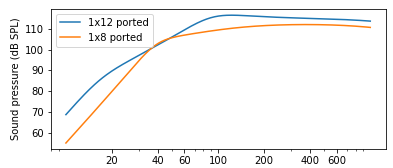

There's not much to say, except that with a little bit of equalization, the speaker should have respectable bass response, but it won't ever be super loud. It's actually a fairly deep sounding speaker.

## Construction in general

The internal dimensions of the box are 12 x 9 x 9.5 inches, and the port is given as 5.5 cm square. My program calls for a roughly 10 inch port, depending on how you account for the volume displaced by the driver. I got away with a trick with my 12" speaker, which is that the port terminates within a couple inches of the baffle, so it is effectively a bent port. I did the same here. Measurement of the port frequency will tell me how close I got!

I've played with a couple of tricks to make this port work. It is technically a shelf port, but with a square cross section. It opens to the side of the box, so it can run along the longest internal dimension. I was able to fashion this port from scrap wood without buying a commercial port tube. I wasn't able to clamp the pieces very well, but it's also not structural in this design.

I built it from 1/2 inch "BC sanded" plywood. This is not the highest grade of lumber, but seems to work just fine for smaller cabinets. I don't have access to a local source of high grade plywood that is not in 4 x 8 foot sheets. This box can be made from a 2 x 4 foot sheet. I used thinner plywood from my scrap pile for the inside walls of the port.

## Now for my construction method

Here are the drawings.

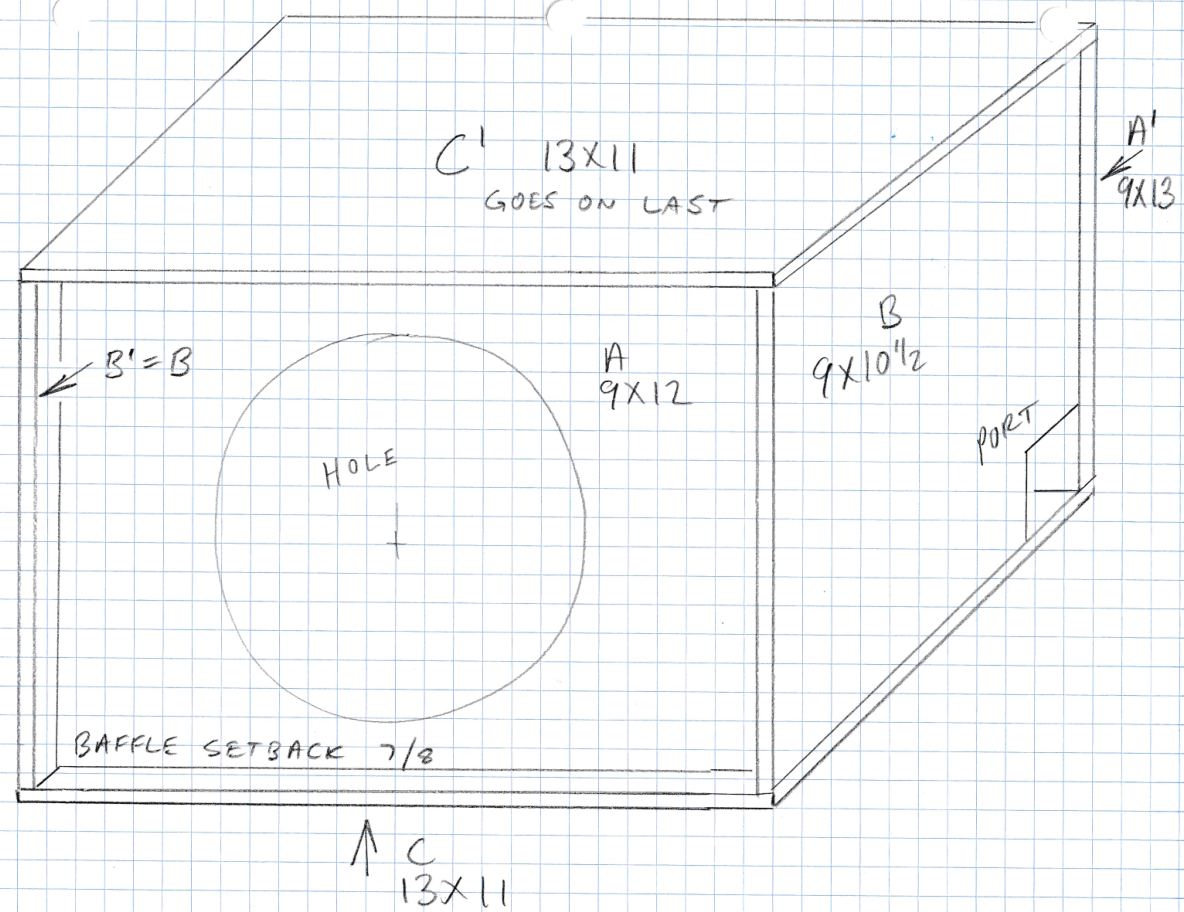
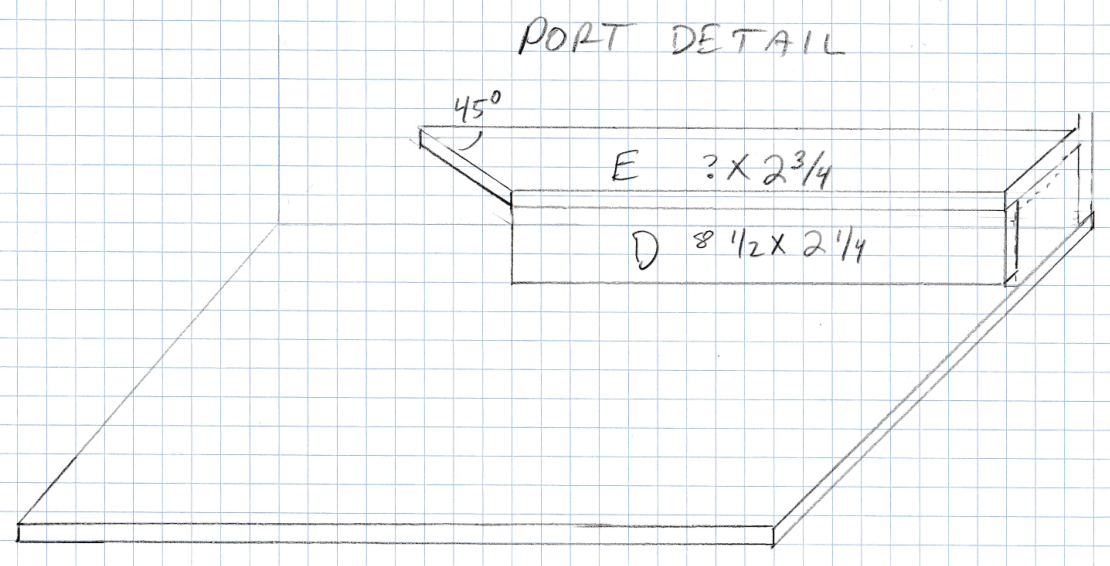

### The rules of my method are:

1. Work safely. If you're not proficient at safe use of the tools you've got, just stop. It's not worth getting injured.
1. Choose the straightest possible plywood panel you can find. You might have to pick through the pieces at the store.
1. Verify my math. You need to be able to prove to yourself that my dimensions are correct! In fact you need to "own" the design. That's why I've shared everything I know.
1. Cut one panel at a time, or at most two if they have identical dimensions. The idea is that if you wait to cut more panels, you can correct for minor dimensional errors as you go. Do some planning:
    1. You don't want to run out of wood. So you should at least lay everything out on a piece of grid paper and plan your cuts
    1. If you have a saw with a fence, cut all of the identical dimensions at the same time, for instance the 9 inch dimensions of panels A, A', B, and B'.
1. Glue the pieces together one at a time. This minimizes the number of clamps and fixtures that you need to own. Verify square with a square. 

1. When you're ready to cut another piece, measure what you've got, in case you need to make minor changes to the dimensions.

1. Glue the next piece on, repeat until done.

### The steps are:

1. Cut panel A. Cut the hole.

1. Cut panels B and B', which should be identical. You can cut the hole for the port in one of the panels at this point.

1. Glue panels A and B

1. Glue panels A and B', making sure everything is square and parallel.

1. Cut and glue panel A' onto the edges of B and B'. Now you have the skeleton of the box.

1. Cut and glue panel C (the bottom), but not C' yet. This will give you access to build the port.

1. Cut and glue D. This is not a structural part.

1. Cut and glue E. This is not a structural part.

1. Finally, cut and glue panel C'.

### Trimming and finishing:

My philosophy is to avoid buying piles of store-bought trimmings. They really add to the cost, and I just don't need them. My gear doesn't get thrown around by roadies, or taken on tour. It doesn't need to look "professional," just unobtrusive. Jazz players and audiences are mostly blind to gear.

1. I rounded all of the edges with sandpaper on a large sanding pad that's sold for drywall finishing, one of my best tool purchases ever.

1. I rounded the edges of the port hole with a router bit, but this could also be done by hand with a wood rasp and sandpaper, or a chisel. I would not go out and buy a router just to make this speaker. And routers have their own safety issues.

1. As you can see, the feet are pads of plywood, glued on, with additional self adhesive rubber feet that I had on hand.

1. For the connector, I drilled part way into the plywood with a hole saw, then cleaned out the hole with a chisel, and drilled the smaller hole all the way through. The hole saw is from fitting a new door to an old house. As you can see in the above picture, I put the connector on the top of the box, so it doesn't interfere with anything when I carry it around "combo style." Likewise, putting the port on the side of the box means that I can shove it up against a wall, or the back of a chair, if I want to.

1. Black Duratex, but ouch the price, even for the small quantities. Today, I'd be looking for something else, even black spray paint. I still have most of a gallon left from when it was cheaper.

1. The speaker is held in by drywall screws into pilot holes. I don't remember if the driver came with a gasket, or I had to make one out of weatherstripping.

1. The grille is actually a "bug eye" grill for an 18 inch speaker. I cut it down to size, then re-used the rubber gasket from the 18-inch grill, just to hide the cut edges.

1. The internal wiring is whatever I had on hand. You could pull apart an old computer power cord (unplug it first), and use its conductors.

1. The handle is a scrap of nylon webbing, held on the sides by more drywall screws and washers. Again, I didn't want to pay for a handle. The strap is long enough to go over the amp head, which is held down by a piece of bike innertube.

## Testing

With a mic close to the cone, I ran a crude response test. The "dip" in the curve is the cone resonance, at roughly 45 Hz. Close enough!

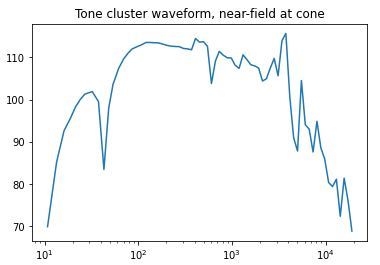

# My current 1x8 and 1x12 bass speaker designs

Francis Deck

This notebook boils all of my design formulas down to a single Python function. It documents two of my designs.

* 12 inch ported system using Eminence 2512-ii driver. I've been quite happy with this design, it's a work horse, and I've been using it for well over a decade, both for electric and upright bass.

* **NEW!** 8 inch ported system using Faital Pro 8PR200, a high performance driver.

I decided to document and analyze both of my designs to serve as an example of using my formulas, plus to check the results carefully with the well known WinISD software.

### License information

The MIT License (MIT) Copyright (c) Francis Deck

Permission is hereby granted, free of charge, to any person obtaining a copy of this 
software and associated documentation files (the "Software"), to deal in the Software 
without restriction, including without limitation the rights to use, copy, modify, 
merge, publish, distribute, sublicense, and/or sell copies of the Software, and 
to permit persons to whom the Software is furnished to do so, subject to the 
following conditions:

The above copyright notice and this permission notice shall be included in all 
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A 
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION 
OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [6]:
from numpy import * # array math library
%matplotlib inline
from matplotlib.pyplot import *
import pandas as pd

In [22]:
# Physical constants

gamma = 1.4 # adiabatic constant, dimensionless
P_atm = 101325 # atmospheric pressure, Pa
rho = 1.225 # density of air, kg/m^3
c = sqrt(gamma*P_atm/rho) # https://en.wikipedia.org/wiki/Speed_of_sound
P_ref = 1 # reference power in Watts
R = 1 # listening distance in meters

f = logspace(1, 3, 300) # a range of frequencies from 10 to 1000 Hz
style = 'WinISD' # preferred style is 'Francis', use 'WinISD to compare results with the WinISD software'

def xCone(w = 2*pi*f, 
          F_s = 37, # free air resonance in Hz
          R_e= 5.04, # series resistance of voice coil in Ohms
          L_e = 0.46*0.001, # inductance of voice coil converted from mH to H
          Q_ms = 3.13, # mechanical contribution to Q factor
          Q_es = 0.44, # electromagnetic contribution to Q factor
          Vas = 147*0.001, # equivalent box volume, liters converted to m^3
          Xmax = 4.90*0.001, # maximum excursion, converted from mm to m
          S_d = 519.5/1e4, # cone area converted from cm^2 to m^2
          
          Znom = 8,
          Pin = 100, # input power used for calculations like cone excursion and port air speed
          V_box = 32*1e-3, # box volume, 32 l converted to m^3
          ported = True,
          f_port = 40, # port tuning frequency in Hz
          Q_port = 50,
          portShape = 'rectangular', # circular or rectangular
          d_port = 100*0.01, # diameter of port if circular in cm converted to m
          a_port = 3.5*0.01, # width of port if rectangular
          b_port = 21.5*0.01, # height of port if rectangular
          endCorrect = 0.732, # port end correction factor
          initReport = {},
          design = '',
         ):
    
    '''
    Compute cone excursion and other performance measures
    
    Parameters are self explanatory, all are in SI units
    '''
    
    w_0 = 2*pi*F_s # resonant frequency in radians/s
    m = gamma*P_atm*S_d**2/w_0**2/Vas # cone mass in kg
    BL = sqrt(w_0*m*R_e/Q_es) # BL product in T*m
    C = w_0*m/Q_ms # Mechanical damping constant of cone
    K = w_0**2*m # Spring constant of cone
    r = sqrt(S_d/pi) # Radius
    z = R_e + 1j*w*L_e # Electrical impedance
    if style == 'WinISD':
        K_box = gamma*P_atm*S_d**2/V_box # Spring constant of box
    elif style == 'Francis':
        Vin = sqrt(Pin*Znom) # Input voltage in Volts RMS
    else:
        print('style must be winISD or Francis')
    Vin = sqrt(Pin*R_e) # Input voltage in Volts RMS
    Vref = sqrt(P_ref*Znom) # Input voltage in Volts RMS
        
    if ported:
        w_port = 2*pi*f_port # port resonant frequency in radians/s
        kappa = w**2/(w**2 - 1j*w*w_port/Q_port - w_port**2) # correction factor for box spring constant based on port behavior
    else:
        kappa = 1 # i.e., no port therefore no port correction

    Keff = K + kappa*K_box # total spring constant, from driver suspension plus port-corrected box
    
    x = BL*Vin/m/z/(Keff/m + 1j*w*(BL**2/m/z + C/m) - w**2) # cone excursion amplitude in meters

    Z = z/(1 - 1j*w*BL*x/Vin) # cone impedance, complex valued, in Ohms

    p = rho*r**2*w**2*kappa*x/R/2 # sound pressure amplitude in Pascal

    p_ref = 20e-6 # reference value for sound pressure, in Pascal
    spl = 20*log10(abs(p)/p_ref) # sound pressure level in dB SPL
    
    phaseRot = 180*pi/180 # phase rotation for phase graph, to make it agree with WinISD
    phase = angle(p*(cos(phaseRot) + 1j*sin(phaseRot)))*180/pi # phase of acoustic wavefront, nearfield
     
    # More ported behavior
    
    if ported:
        kappa2 = w_port**2/(w**2 - 1j*w*w_port/Q_port - w_port**2)
        
        if portShape == 'circular':
            S_port = pi*d_port**2/4
            Rport = d_port/2
        elif portShape == 'rectangular': 
            S_port = a_port*b_port
            Rport = min([a_port, b_port])/2 # assume effective radius is the smaller of the two dimensions
        else:
            print('portShape needs to be circular or rectangular')
        
        v_port = 1j*w*kappa2*x*S_d/S_port/c # speed of port air plug
        
        lport = S_port*gamma*P_atm/rho/V_box/w_port**2 - Rport*2*endCorrect # length of port in meters
        
    else:
        v_port = None
        
    report = dict(initReport)
    report['resonant angular frequency w_0 (1/s)'] = w_0
    report['cone mass m (kg)'] = m
    report['magnetic field length product BL (T m)'] = BL
    report['mechanical damping factor (N/(m/s))'] = C
    report['mechanical spring constant (N/m)'] = K
    report['mechanical compliance (m/N)'] = 1/K
    report['cone radius (m)'] = r
    report['box spring constant (N/m)'] = K_box
    report['Port angular frequency (1/s)'] = w_port
    report['Port area (m^2)'] = S_port
    report['Port effective radius (m)'] = Rport
    report['Length of port (m)'] = lport
    report['Length of port (in)'] = lport*39.3
        
    return x, Z, spl, phase, v_port, p, pd.DataFrame([[tag, report[tag]] for tag in report])

def graphs(f, x, Z, spl, phase, v_port, label):
    ax[0].semilogx(f, abs(x)*1000*1.414, label = label)
    ax[0].set_ylabel('cone excursion amplitude (mm)')
    
    ax[1].semilogx(f, abs(Z), label = label)
    ax[1].set_ylabel(r'impedance ($\Omega$)')

    ax[2].semilogx(f, spl, label = label)
    ax[2].set_ylabel('Sound pressure (dB SPL)')

    ax[3].semilogx(f, phase, label = label)
    ax[3].set_ylabel('Phase')

    ax[4].semilogx(f, abs(v_port)*1.414, label = label)
    ax[4].set_xlabel('frequency (Hz)')
    ax[4].set_ylabel('port air speed (mach)')
    
    for a in ax:
        a.set_xticks([20, 40, 60, 100, 200, 400, 600])
        a.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        a.legend()
    
def runGraph(name, driver, box):
    x, Z, spl, phase, v_port, p1, df = xCone(**(name | driver | box), initReport = name | driver | box) 
    label = name['design']
    graphs(f, x, Z, spl, phase, v_port, label)
    return df

In [23]:
# Driver library.

emi2512ii = { # Eminence DeltaLite 2512-ii
    'F_s': 37, # resonant frequency in Hz
    'R_e': 5.04, # series resistance of voice coil in Ohms
    'L_e': 0.46*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 3.13, # mechanical contribution to Q factor
    'Q_es': 0.44, # electromagnetic contribution to Q factor
    'Vas': 147*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 4.90*0.001, # maximum excursion, converted from mm to m
    'S_d': 519.5/1e4, # cone area converted from cm^2 to m^2
}

fp8pr200 = { # Faital Pro 8PR200
    'F_s': 58, # resonant frequency in Hz
    'R_e': 5.1, # series resistance of voice coil in Ohms
    'L_e': 0.55*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 9.4, # mechanical contribution to Q factor
    'Q_es': 0.38, # electromagnetic contribution to Q factor
    'Vas': 16.9*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 8.15*0.001, # maximum excursion, converted from mm to m
    'S_d': 209/1e4, # cone area converted from cm^2 to m^2
}

# Box database

box1 = { # My little 12" box
    'Znom': 8,
    'Pin': 100,
    'V_box': 32*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 40, # port tuning frequency in Hz
    'Q_port': 10, # value borrowed from WinISD
    'portShape': 'rectangular', # circular or rectangular
    'd_port': None, # diameter of port if circular in cm converted to m
    'a_port': 3.5*0.01, # width of port if rectangular
    'b_port': 21.5*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

box2 = {
    'Znom': 8,
    'Pin': 100,
    'V_box': 15*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 40, # port tuning frequency in Hz
    'Q_port': 10, # value borrowed from WinISD
    'portShape': 'rectangular', # circular or rectangular
    'd_port': None, # diameter of port if circular in cm converted to m
    'a_port': 5.5*0.01, # width of port if rectangular
    'b_port': 5.5*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

box3 = {
    'Znom': 8,
    'Pin': 100,
    'V_box': 15*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 45, # port tuning frequency in Hz
    'Q_port': 10, # value borrowed from WinISD
    'portShape': 'rectangular', # circular or rectangular
    'd_port': None, # diameter of port if circular in cm converted to m
    'a_port': 5.5*0.01, # width of port if rectangular
    'b_port': 5.5*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

,0,1,2,3
0,design,1x12 ported,1x8 design,1x8 as built
1,F_s,37,58,58
2,R_e,5.04,5.1,5.1
3,L_e,0.00046,0.00055,0.00055
4,Q_ms,3.13,9.4,9.4
5,Q_es,0.44,0.38,0.38
6,Vas,0.147,0.0169,0.0169
7,Xmax,0.0049,0.00815,0.00815
8,S_d,0.05195,0.0209,0.0209
9,Znom,8,8,8


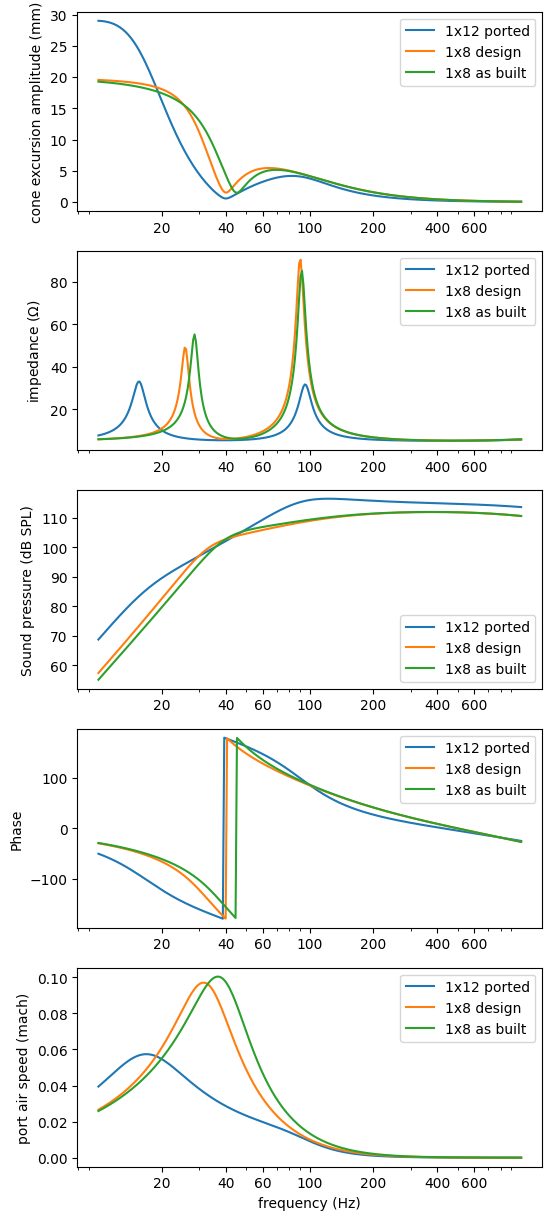

In [24]:
fig, ax = subplots(5, 1, figsize = (6, 15))

df1 = runGraph({'design': '1x12 ported'}, emi2512ii, box1)
df2 = runGraph({'design': '1x8 design'}, fp8pr200, box2)
df3 = runGraph({'design': '1x8 as built'}, fp8pr200, box3)

df1[2] = df2[1]
df1[3] = df3[1]
display(df1)

# Graphs for these designs from WinISD

There's a disagreement between me and WinISD, as to how we calculate the signal in Volts feeding the speaker, see above
for the "style" parameter. WinISD uses the $R_e$ of the coil, I use the nominal impedance. I've set the "style" to WinISD
for the purpose of comparison.

### Excursion amplitude
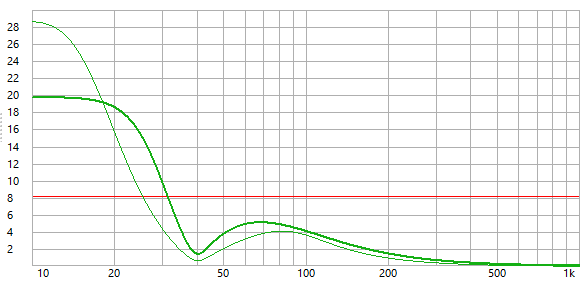

### Impedance
I get the same peak frequencies as WinISD, but noticeably different peak heights

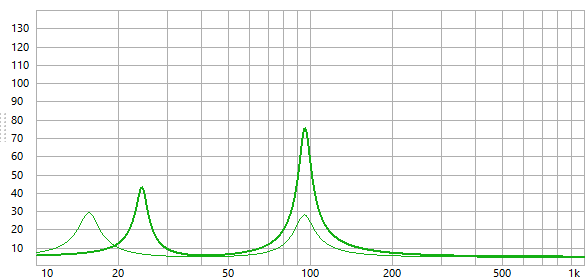

### SPL
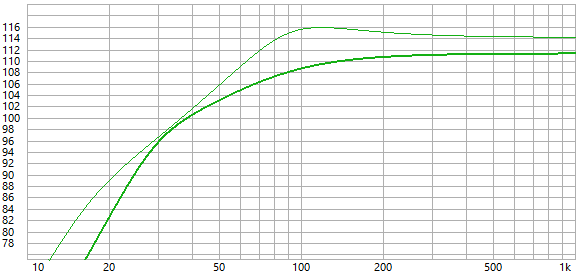

### Phase

I added a 180$^{\circ}$ phase rotation to make my graph match WinISD. This shouldn't have an acoustic effect, but is useful for comparing the programs.

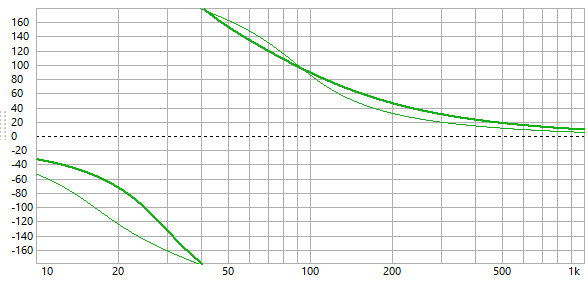

### Port air speed
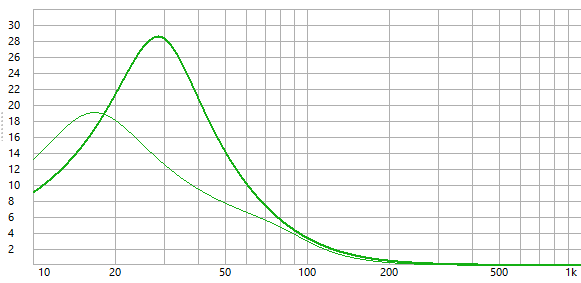

In [25]:
# don't forget to save before running this cell...
!jupyter nbconvert --to html "12 and 8 inch designs.ipynb"

[NbConvertApp] Converting notebook 12 and 8 inch designs.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 4041132 bytes to 12 and 8 inch designs.html
